Figures we need:
- similarity matrix of the somato-motor network
- model matrix of the noise regression GLM
- sorted weight matrices for the somato-motor network
- raw (non-regressed) seed maps for individuals from one cluster
- the corresponding regressed seed maps for these individuals
- a nice representation of the somato-motor network

Regarding the maps: 

If this doesn't look good enough with the nilearn plotting options, then we can also use MRIcroGL.

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
#import seaborn as sb
import brainbox as bb
import nibabel as nib
import nilearn as nil
from scipy import io as sio
from matplotlib import gridspec
from nilearn import plotting as nlp
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline

In [4]:
# Network name lookup table
sc7_names = [
             'Cerebellum',
             'Limbic',
             'Somatomotor',
             'Visual',
             'Default Mode',
             'Frontoparietal',
             'Ventral Attention'
            ]
sc12_names = [
              'Basal Ganglia',
              'Auditory',
              'Limbic',
              'Lateral Default Mode',
              'Visual',
              'Posterior medial Default Mode',
              'Somatomotor',
              'Anterior Default Mode',
              'Higher Visual',
              'Frontoparietal',
              'Ventral Attention',
              'Cerebellum'
              ]

In [5]:
# Paths
somatomotor_path = '/data1/guilimin/abide/subtype/sc7/full_maybe/network_3/'
subtype_path = 'network_3_subtype.mat'
stack_path = 'network_3_stack.mat'
model_path = '/data1/guilimin/abide/pheno/sc7/model_full_maybe_sc7.csv'
mas_path = '/data1/guilimin/abide/masks/template_mask.nii.gz'

figure_path = '/home/surchs/GDrive/PhD/Conferences/HBM2016/Poster/Figures/'

In [6]:
m_img = nib.load(mas_path)
mask = m_img.get_data().astype(bool)
m_vec = np.reshape(mask, np.prod(mask.shape), order='F')

## Similarity Matrix

In [7]:
submat = sio.loadmat(os.path.join(somatomotor_path, subtype_path))

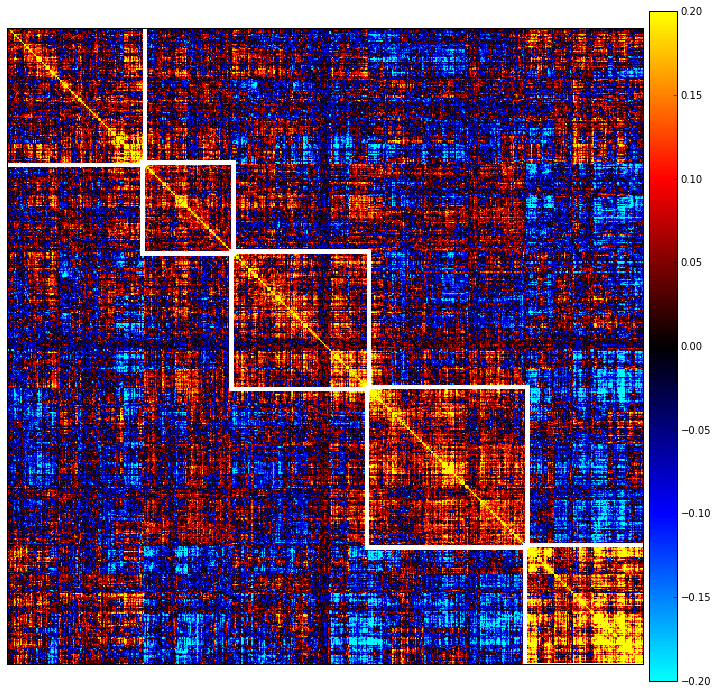

In [8]:
# Make the map
simmat = submat['sim_matrix']
order = submat['subj_order']
order = np.array([np.int(x) for x in order], dtype=int)

part = submat['part']
part_ord = part[order-1]
show_mat = simmat[order-1, :][:, order-1]

part_frame = np.zeros(simmat.shape)

for sbt_id in np.arange(5):
    # Get first and last element
    hits = np.where(part_ord==sbt_id+1)[0]
    first = hits[0]
    last = hits[-1]
    if first > 1:
        # We can probably go back 4
        frontup = (first-3, first-2, first-1, first)
        selstart = first-3
    else:
        frontup = (first,)
        selstart = first
    if last < part_frame.shape[0] - 3:
        # we can probably extend 4
        backtup = (last, last+1, last+2, last+3)
        selstop = last+3
    else:
        backtup = (last,)
        selstop = last
    # Draw column
    devtuple = frontup + backtup
    part_frame[selstart:selstop, devtuple] = 1
    # Draw rows 
    part_frame[devtuple, selstart:selstop] = 1
part_frame = np.ma.masked_where(part_frame == 0, part_frame)

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(1, 20, hspace=0)
ax_1 = fig.add_subplot(gs[0, :-1])
tmp = ax_1.matshow(show_mat, vmin=-0.2, vmax=0.2, cmap=bb.visu.hot_cold())
ax_1.matshow(part_frame, cmap=plt.cm.Greys, alpha=1)
ax_1.set_xticklabels([])
ax_1.set_yticklabels([])

ax_2 = fig.add_subplot(gs[0, -1])
plt.colorbar(tmp, cax=ax_2)


fig_name = 'somatomotor_simmat_lines.png'
fig.savefig(os.path.join(figure_path, fig_name), transparent=False, bbox_inches='tight',
            pad_inches=0)

In [9]:
# Show the noise regression model
model = pd.read_csv(model_path)
model.head()
tmp = model
tmp.rename(columns={'SUB_ID': 'Intercept'}, inplace=True)
tmp['Intercept'] = np.ones(tmp.shape[0])
# Normalize stuff
tmp.AGE_AT_SCAN = (tmp.AGE_AT_SCAN - np.mean(tmp.AGE_AT_SCAN))/np.std(tmp.AGE_AT_SCAN)
tmp.FD_scrubbed = (tmp.FD_scrubbed - np.mean(tmp.FD_scrubbed))/np.std(tmp.FD_scrubbed)
#tmp.DX_GROUP.replace({2:0}, inplace=True)
tmp.drop('DX_GROUP', axis=1, inplace=True)

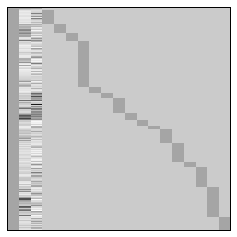

In [10]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.matshow(tmp.as_matrix(), cmap=plt.cm.Greys, aspect='auto')
ax.set_xticks([])
ax.set_yticks([])
fig_name = 'noise_model_matrix.png'
fig.savefig(os.path.join(figure_path, fig_name), transparent=False, bbox_inches='tight',
            pad_inches=0)

In [11]:
# Show some uncorrected maps and then the corresponding corrected maps
order = submat['subj_order']
order = np.array([np.int(x) for x in order], dtype=int)
part = submat['part']
# Get some subjects from subtype 2 and some from subtype 3 for contrast
sbt2 = np.where(part==2)[0]
sbt3 = np.where(part==3)[0]

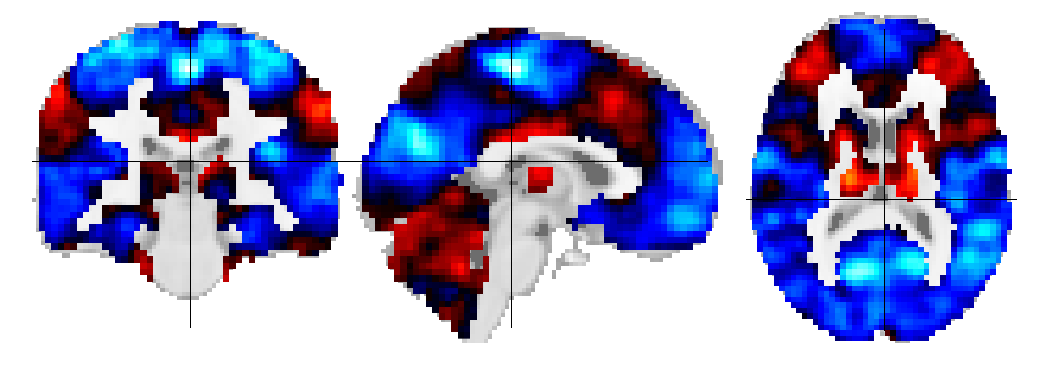

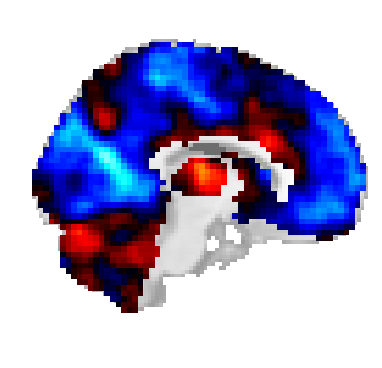

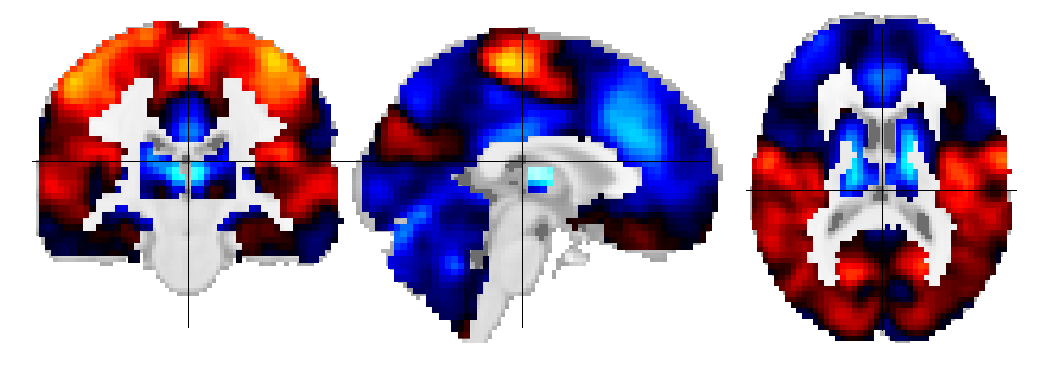

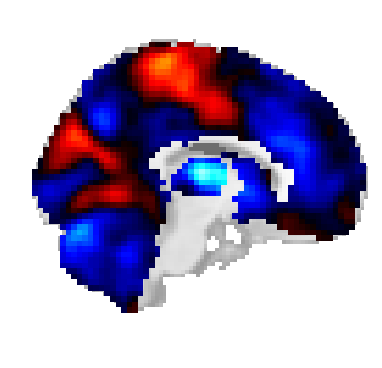

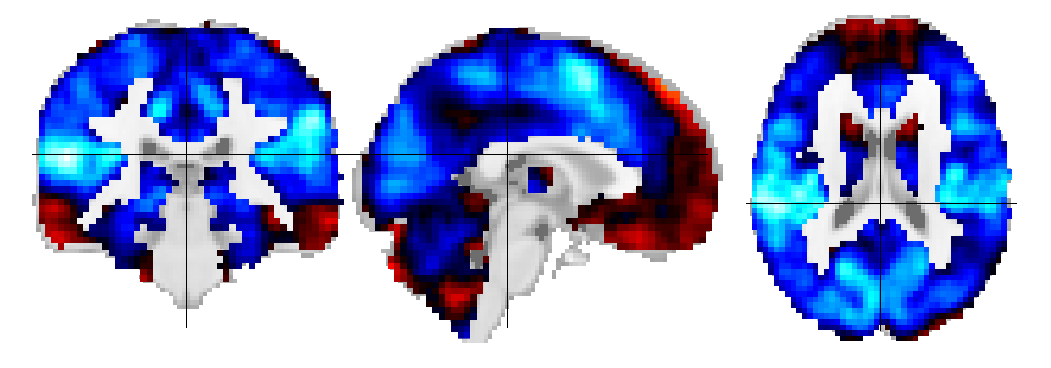

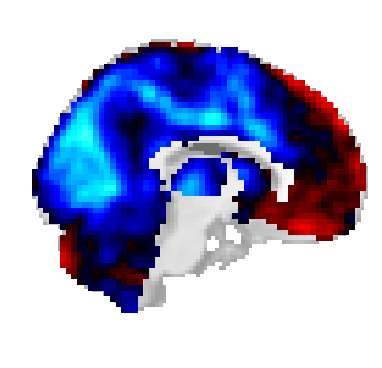

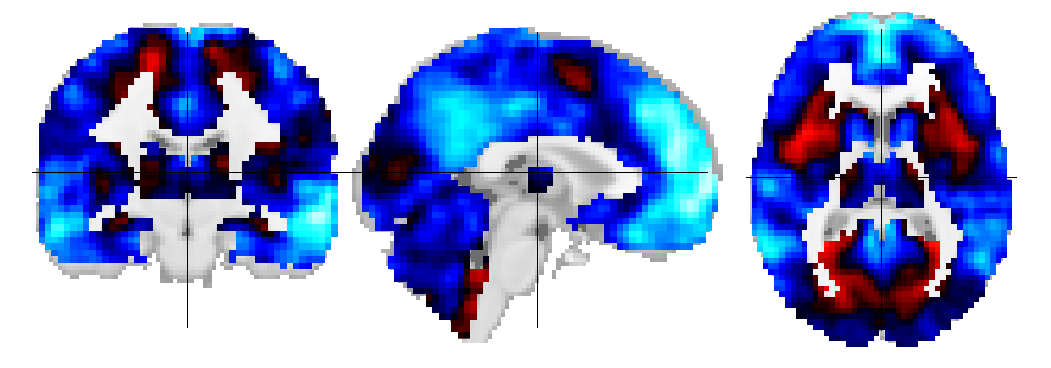

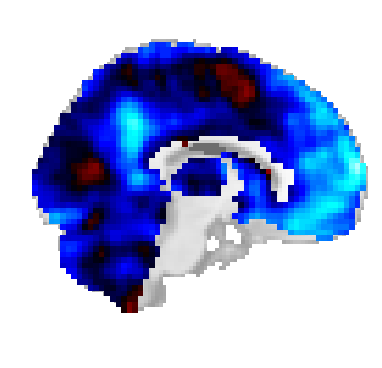

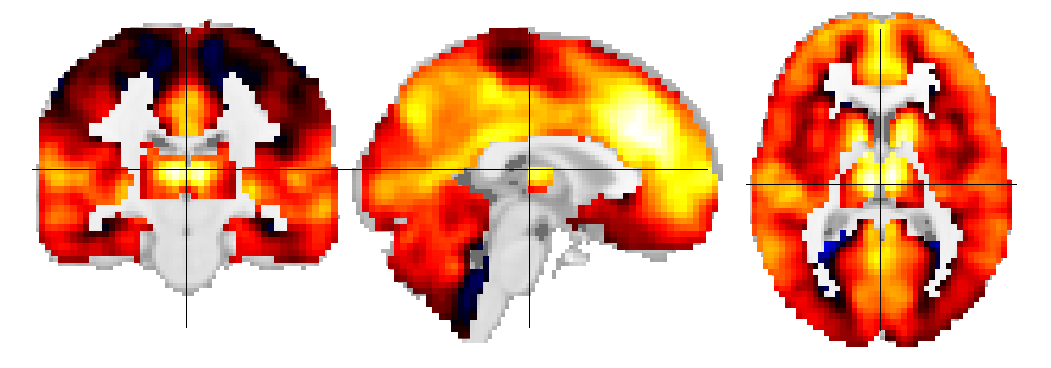

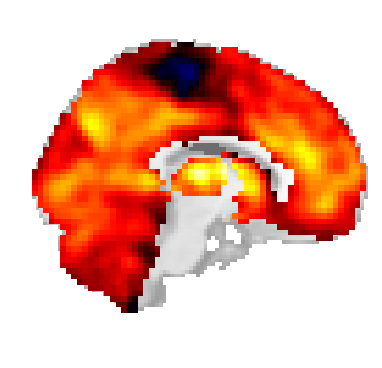

In [12]:
# Show the subtype maps for the somatomotor network
sbt = sio.loadmat('/data1/guilimin/abide/subtype/sc7/full_maybe/network_3/network_3_subtype.mat')
ns = sio.loadmat('/data1/guilimin/abide/subtype/sc7/full_maybe/network_3/network_3_stack.mat')
stack = ns['stack']
part = submat['part'].flatten()
m_vec = np.reshape(mask, np.prod(mask.shape), order='F')

for subtype in np.arange(5)+1:
    tmp = np.zeros_like(m_vec, dtype=float)
    tmp[m_vec] = np.mean(stack[part==subtype, :],0)/np.std(stack[part==subtype, :])
    tmp = np.reshape(tmp, mask.shape, order='F')

    s_img = nib.Nifti1Image(tmp, header=m_img.get_header(), affine=m_img.get_affine())
    fig = plt.figure(figsize=(18,6))
    ax = fig.add_subplot(111)
    nlp.plot_stat_map(s_img, display_mode='ortho', threshold=0, annotate=False,
                      black_bg=False,axes=ax, colorbar=False)
    
    s_name = 'net_3_subtype_{}_map_norm.png'.format(subtype)
    fig.savefig(os.path.join(figure_path, s_name), transparent=False, bbox_inches='tight',
            pad_inches=0)
    
    
    figx = plt.figure(figsize=(6,6))
    ax = figx.add_subplot(111)
    nlp.plot_stat_map(s_img, display_mode='x', threshold=0, annotate=False, cut_coords=[-10],
                      black_bg=False,axes=ax, colorbar=False)
    
    s_name = 'x_net_3_subtype_{}_map_norm.png'.format(subtype)
    figx.savefig(os.path.join(figure_path, s_name), transparent=False, bbox_inches='tight',
            pad_inches=0)

In [13]:
# Now show the raw images
model = pd.read_csv(model_path)
seed_tmp = '/data1/guilimin/abide/sca_z/sc7/netstack_fmri_{:07}_session_1_run1.nii.gz'
for sbt_id in np.arange(5)+1:
    sbt_ind = np.where(part==sbt_id)[0]
    sub_path = os.path.join(figure_path, 'sub{}'.format(sbt_id))
    if not os.path.isdir(sub_path):
        os.makedirs(sub_path)
    for ids in np.arange(7):
        s_name = 'sub_{:07}'.format(model.iloc[sbt_ind[ids]].SUB_ID.astype(int))
        t = nib.load(seed_tmp.format(model.iloc[sbt_ind[ids]].SUB_ID.astype(int)))

        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)
        nlp.plot_stat_map(nil.image.index_img(t, 2), display_mode='x', threshold=0, annotate=False, cut_coords=[-10],
                          black_bg=False,axes=ax, colorbar=False)
        fig_name = 'x_raw_{}_net_3_sbt_{}.png'.format(s_name, sbt_id)
        fig.savefig(os.path.join(sub_path ,fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)

        plt.close()

/home/surchs/Venv/serv3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


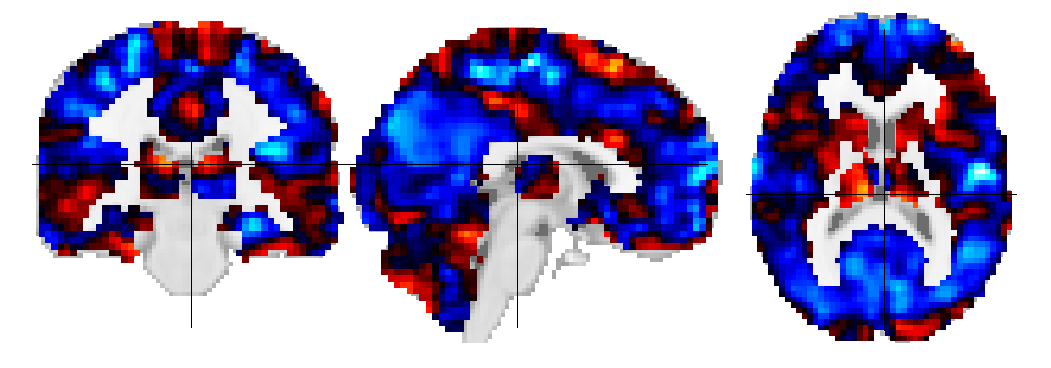

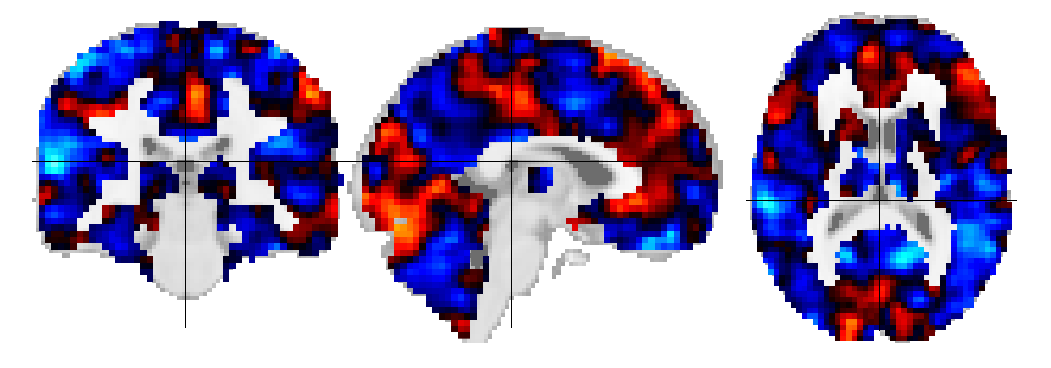

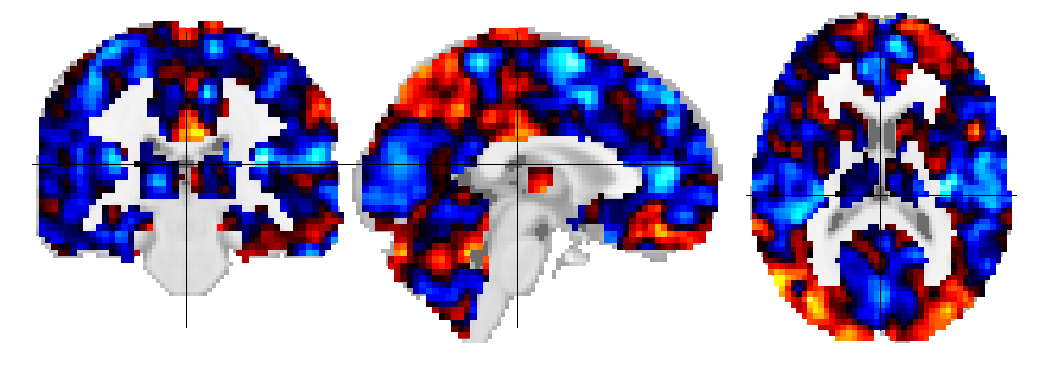

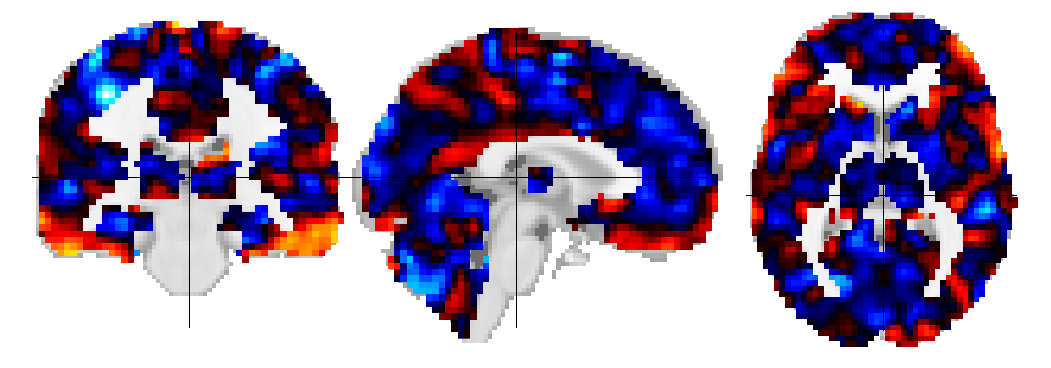

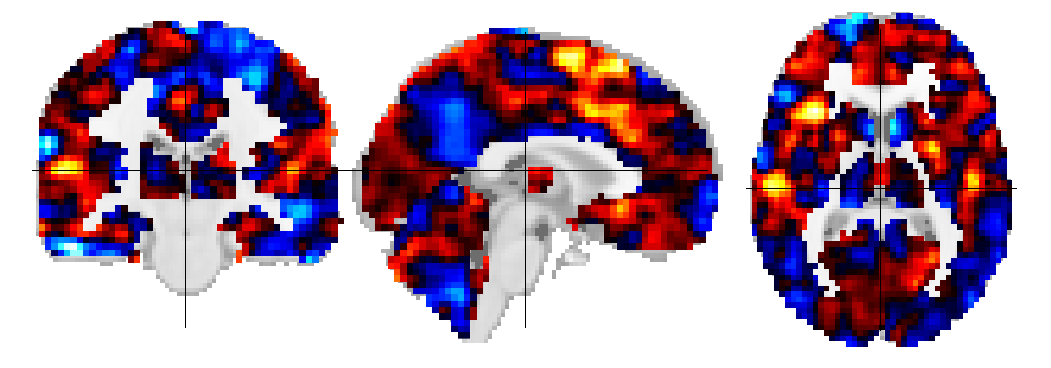

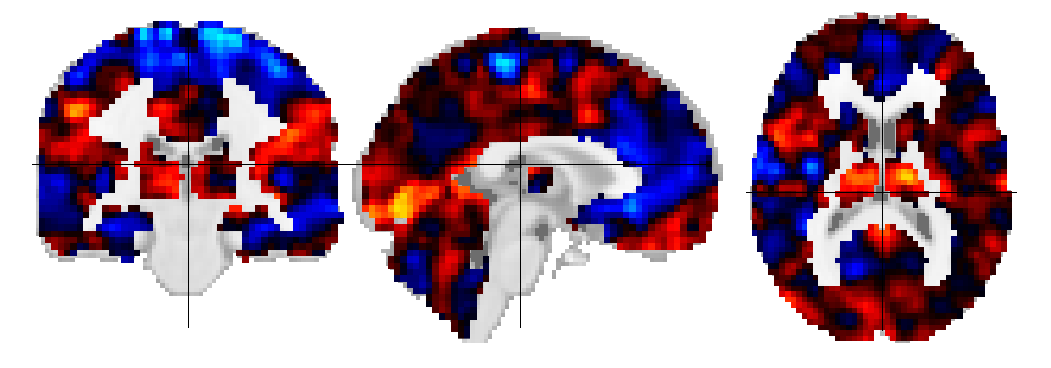

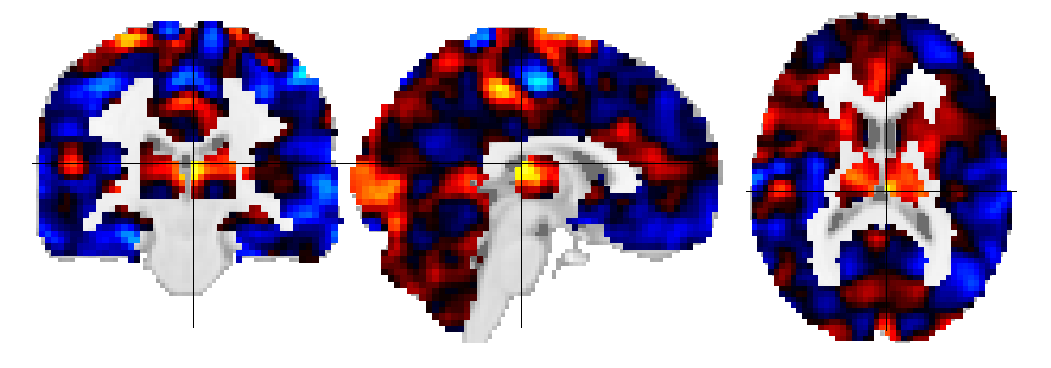

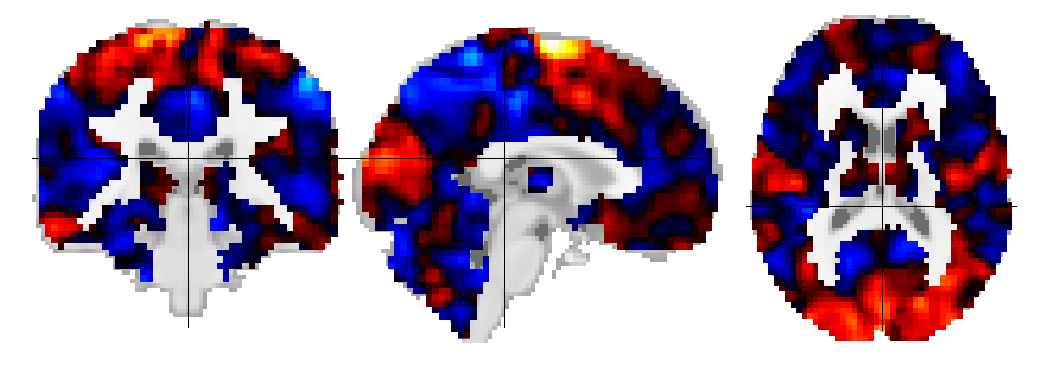

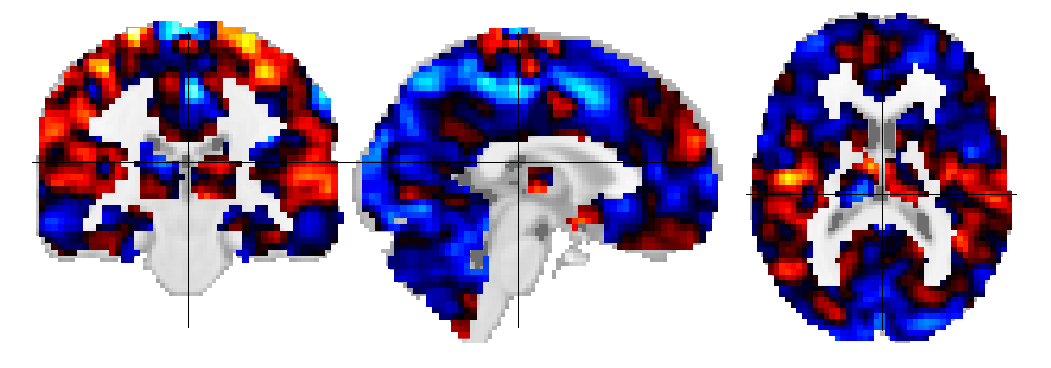

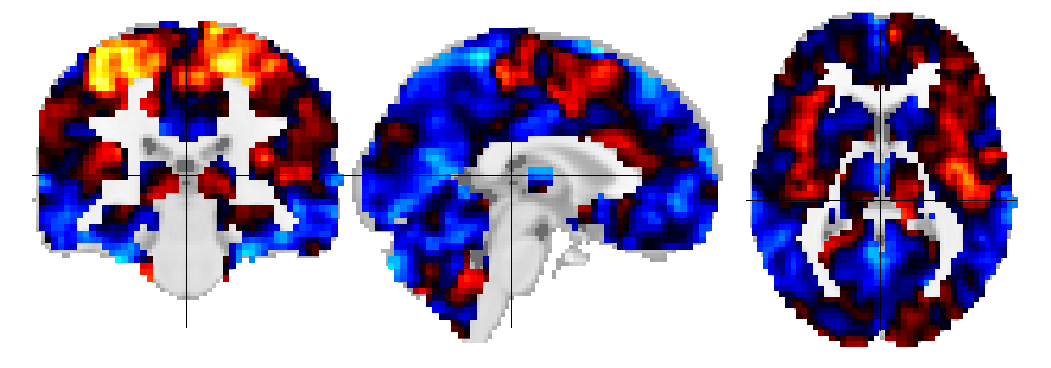

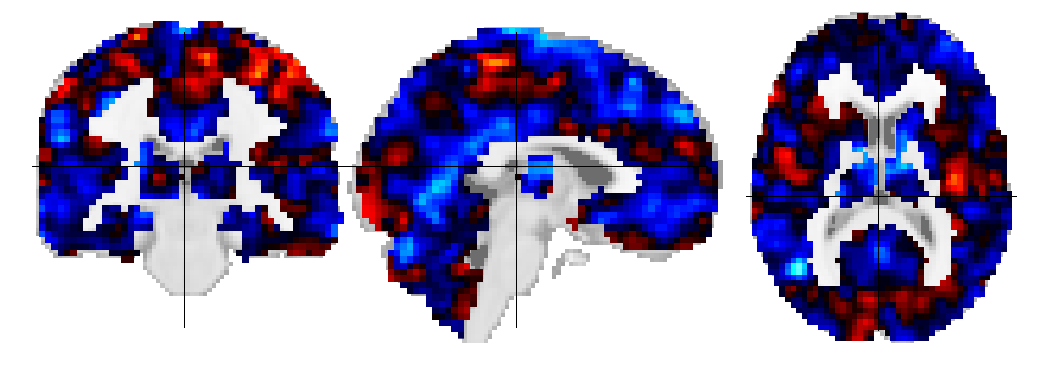

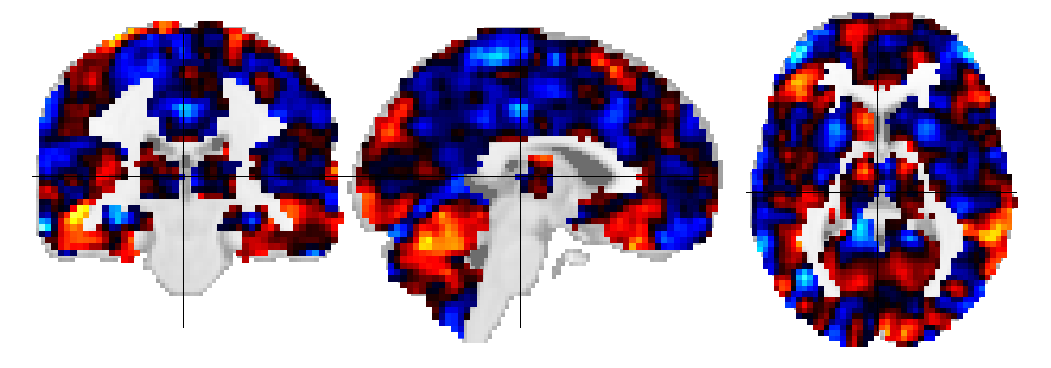

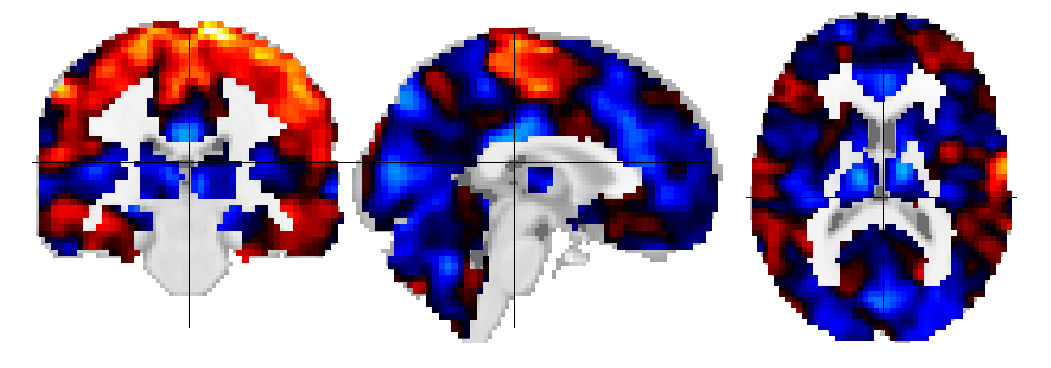

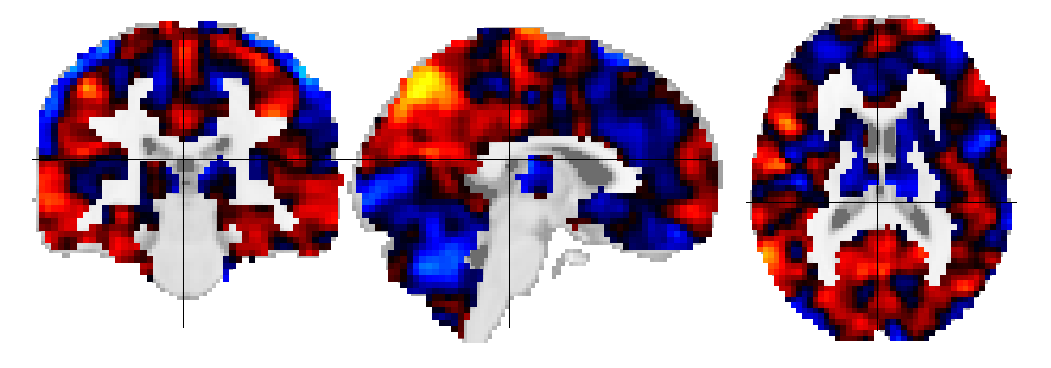

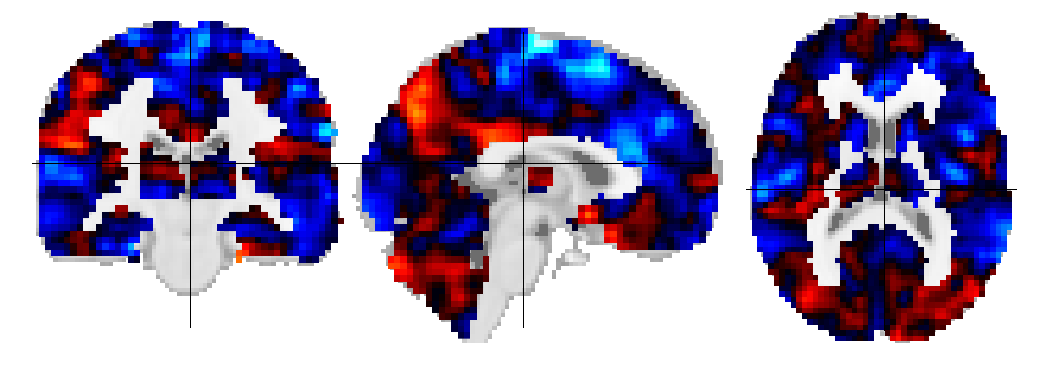

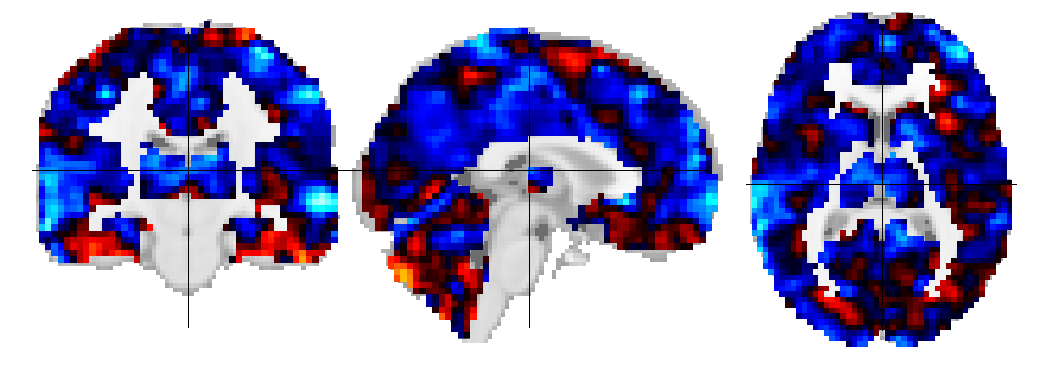

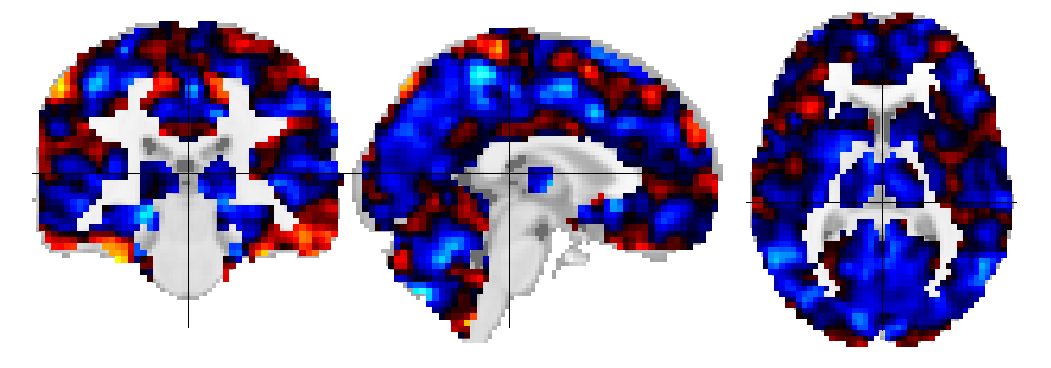

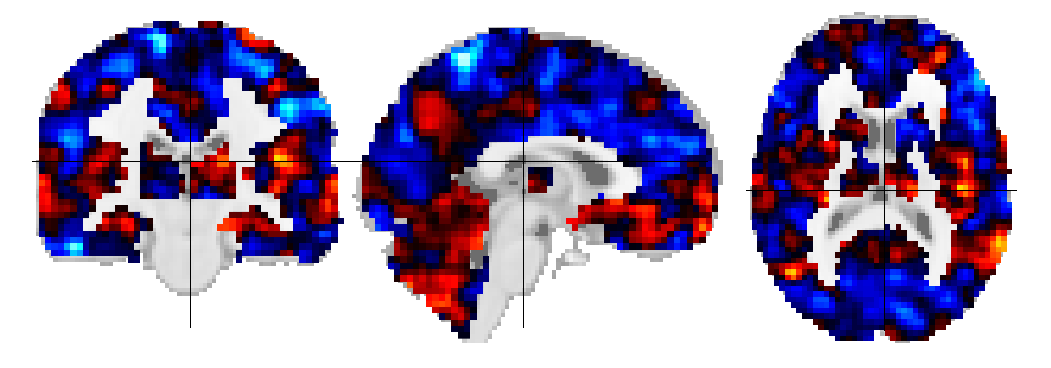

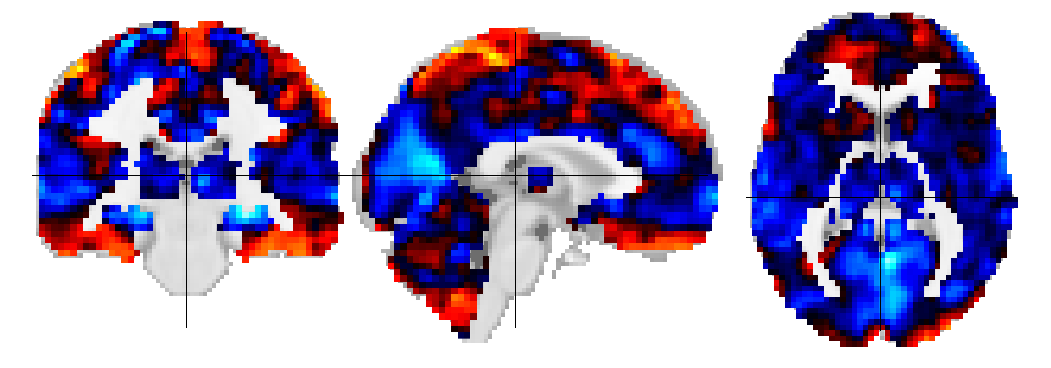

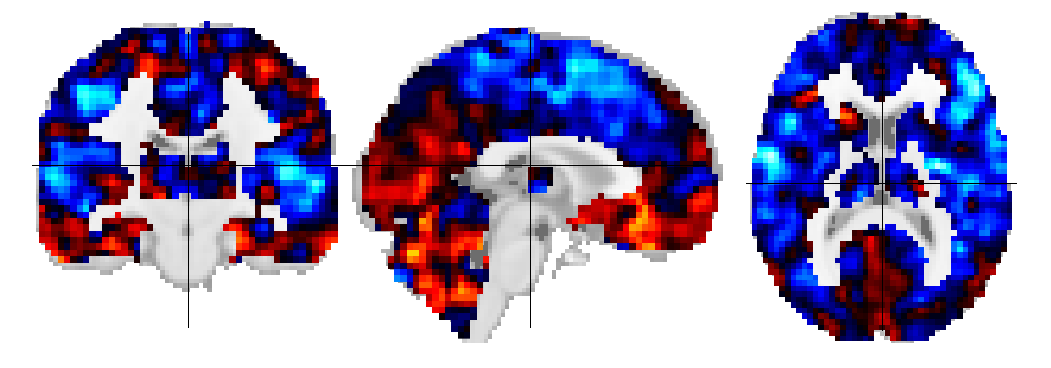

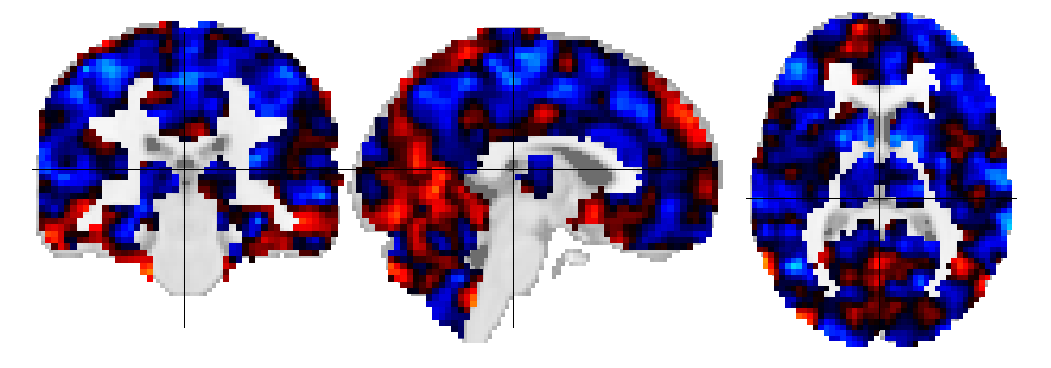

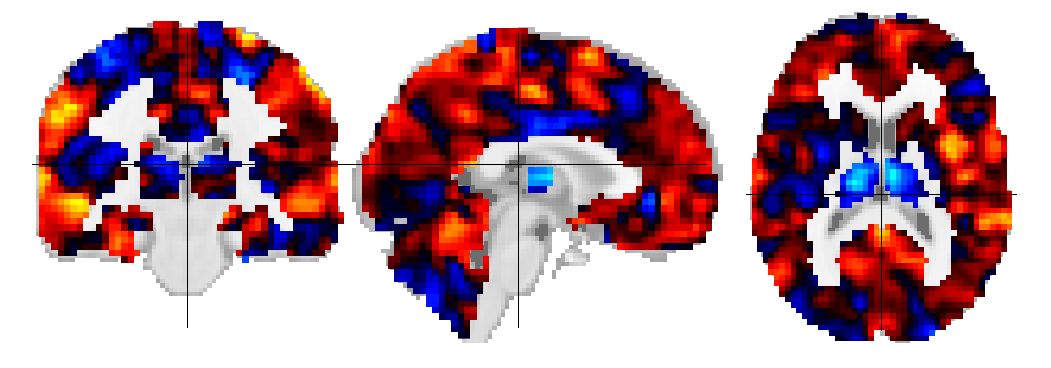

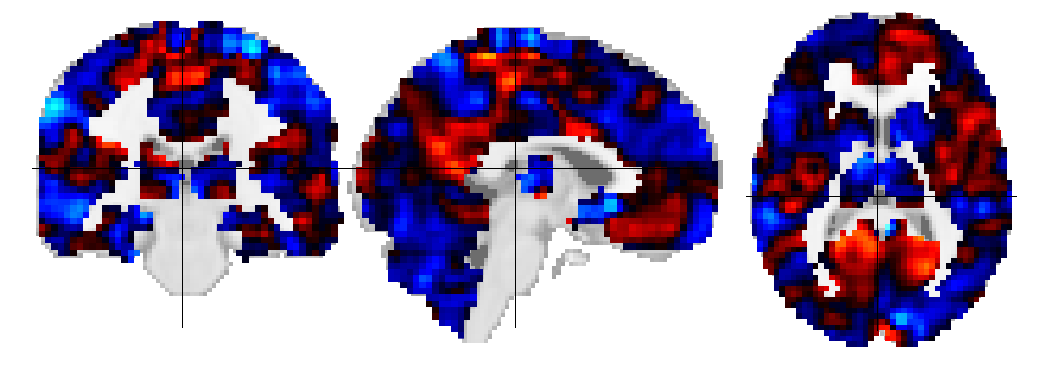

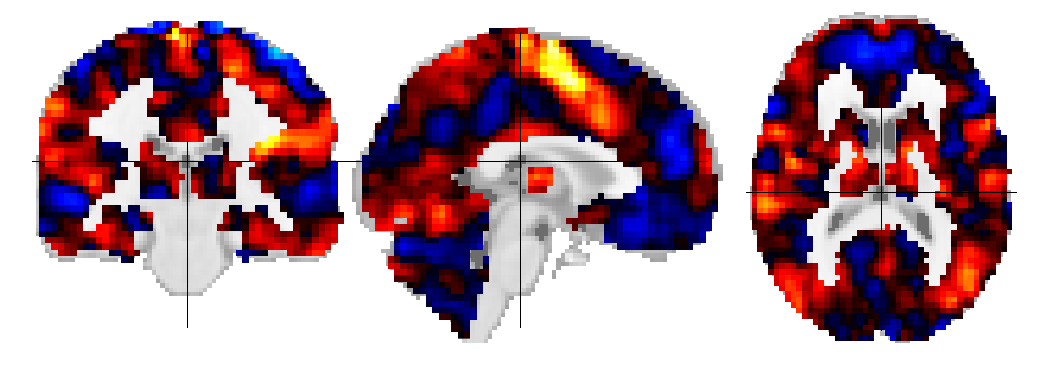

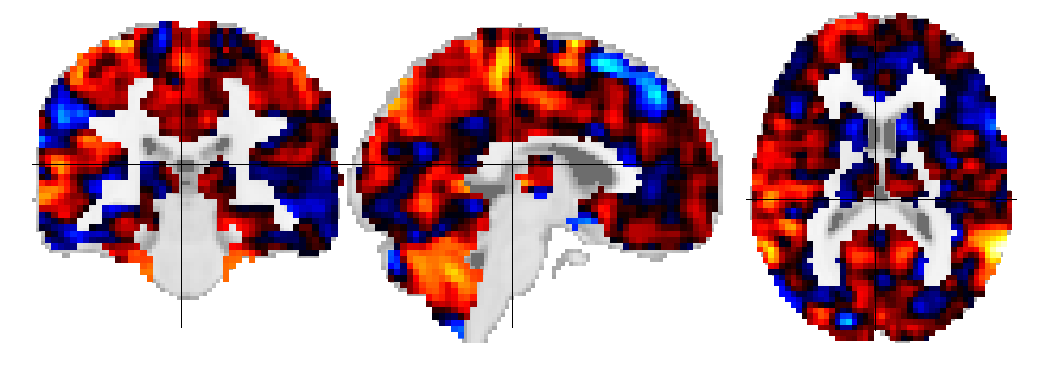

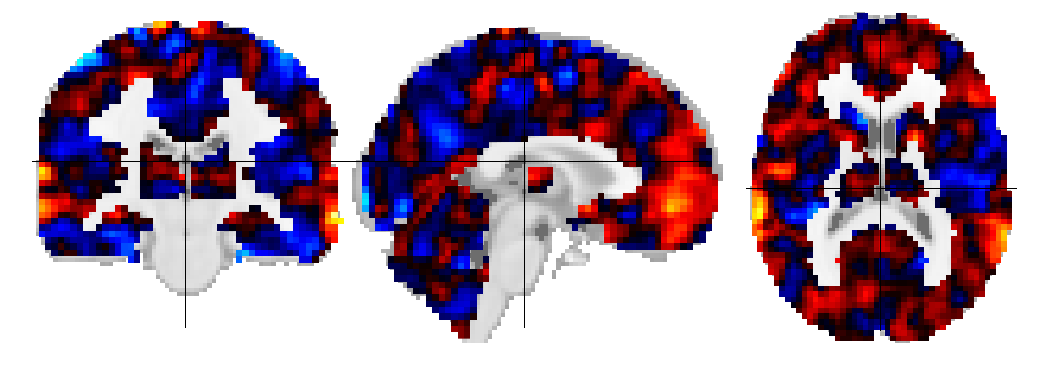

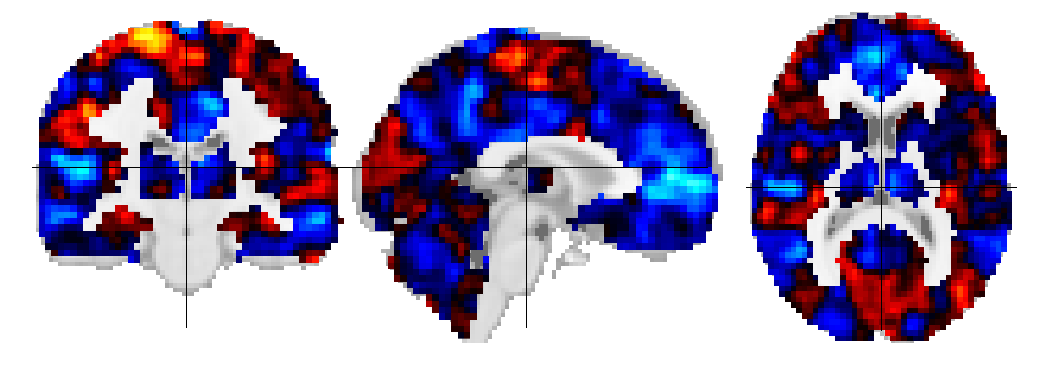

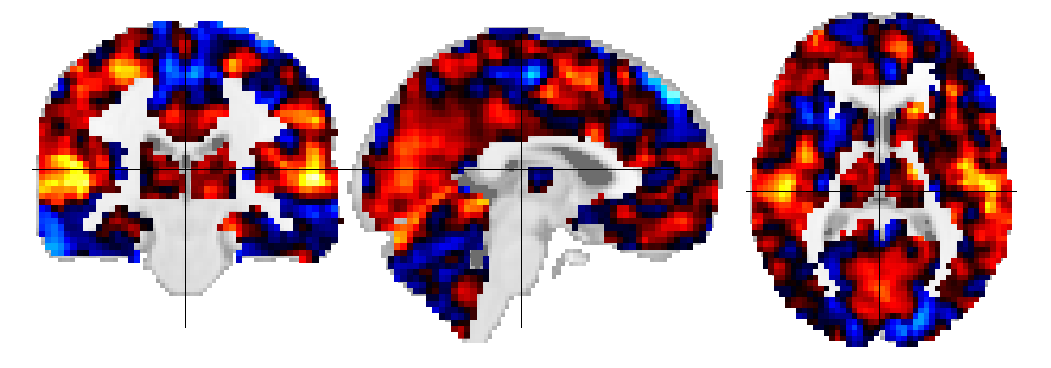

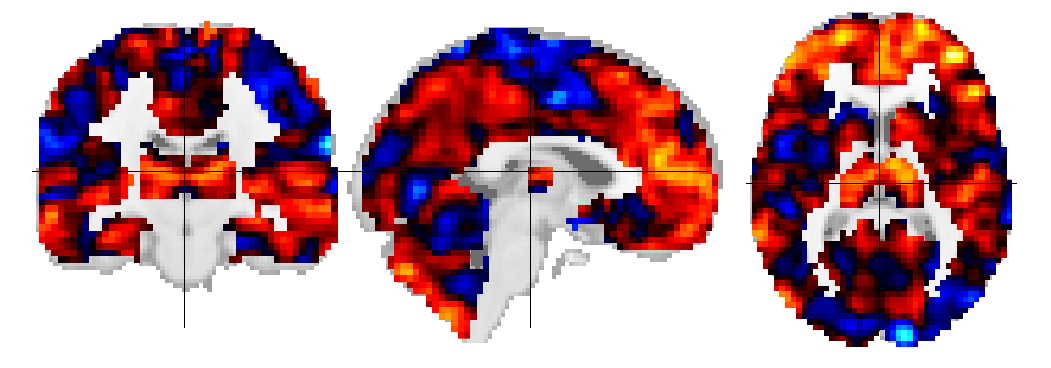

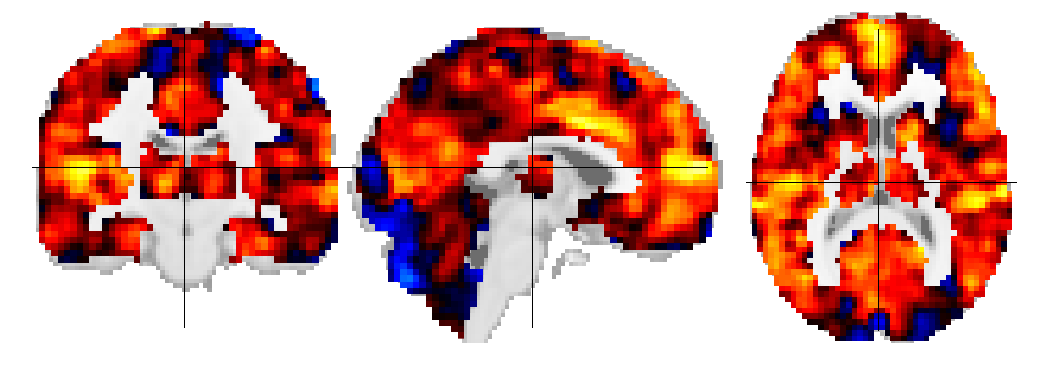

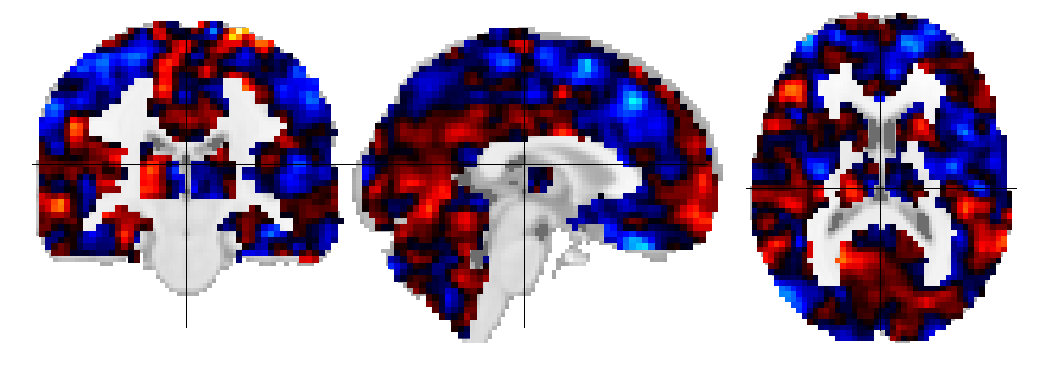

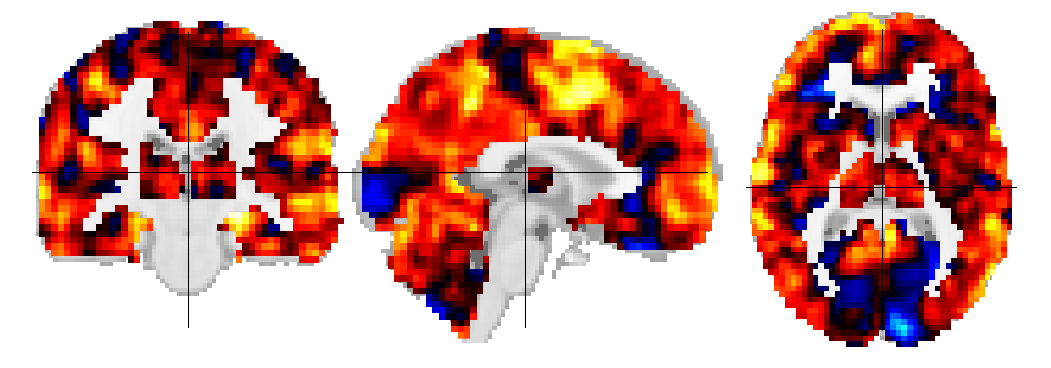

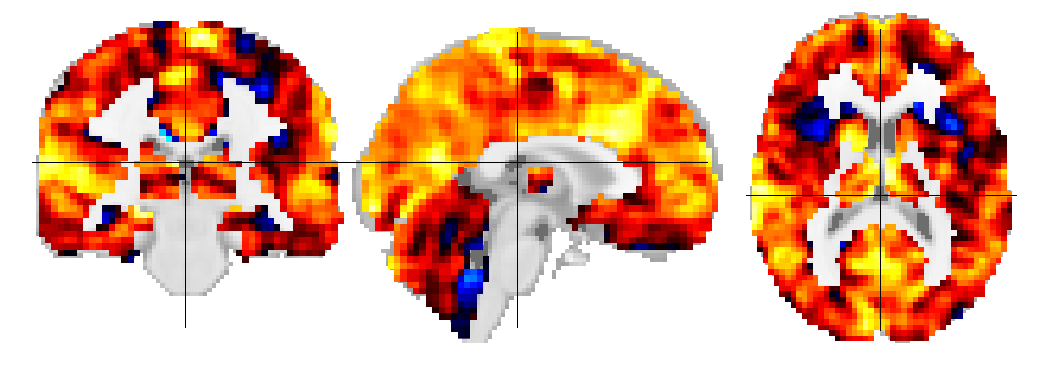

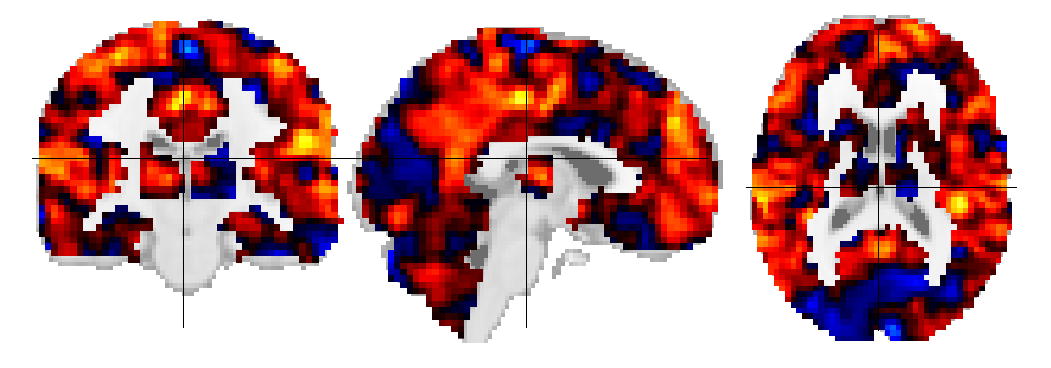

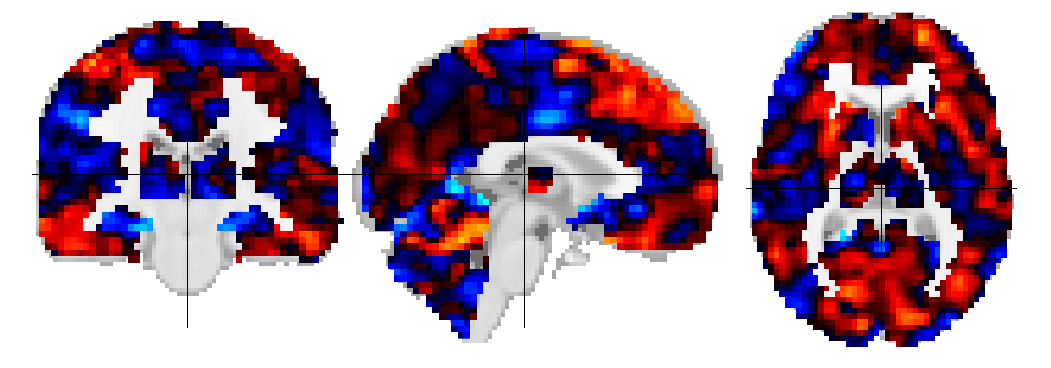

In [14]:
# Get the network stack
m_img = nib.load(mas_path)
mask = m_img.get_data().astype(bool)
m_vec = np.reshape(mask, np.prod(mask.shape), order='F')

model = pd.read_csv(model_path)
seed_tmp = '/data1/guilimin/abide/sca_z/sc7/netstack_fmri_{:07}_session_1_run1.nii.gz'

m_vec = np.reshape(mask, np.prod(mask.shape), order='F')
ns = sio.loadmat('/data1/guilimin/abide/subtype/sc7/full_maybe/network_3/network_3_stack.mat')
stack = ns['stack']

for sbt_id in np.arange(5)+1:
    sbt_ind = np.where(part==sbt_id)[0]
    sub_path = os.path.join(figure_path, 'sub{}'.format(sbt_id))
    if not os.path.isdir(sub_path):
        os.makedirs(sub_path)
    for ids in np.arange(7):

        s_num = model
        s2_name = 'sub_{:07}'.format(model.iloc[sbt_ind[ids]].SUB_ID.astype(int))

        tmp2 = np.zeros_like(m_vec, dtype=float)
        tmp2[m_vec] = stack[sbt_ind[ids], :]
        tmp2 = np.reshape(tmp2, mask.shape, order='F')
        s2_img = nib.Nifti1Image(tmp2, header=m_img.get_header(), affine=m_img.get_affine())

        fig_2 = plt.figure(figsize=(18,6))
        ax = fig_2.add_subplot(111)
        nlp.plot_stat_map(s2_img, display_mode='ortho', threshold=0, annotate=False,
                          black_bg=False,axes=ax, colorbar=False)
        fig2_name = 'regressed_{}_net_3_sbt_{}.png'.format(s2_name, sbt_id)
        fig_2.savefig(os.path.join(sub_path, fig2_name), transparent=False, bbox_inches='tight',
                pad_inches=0)

        fig_2x = plt.figure(figsize=(6,6))
        ax = fig_2x.add_subplot(111)
        nlp.plot_stat_map(s2_img, display_mode='x', threshold=0, annotate=False, cut_coords=[-10],
                          black_bg=False,axes=ax, colorbar=False)
        fig2x_name = 'x_regressed_{}_net_3_sbt_{}.png'.format(s2_name, sbt_id)
        fig_2x.savefig(os.path.join(sub_path, fig2x_name), transparent=False, bbox_inches='tight',
                pad_inches=0)

        plt.close()

In [19]:
# Get the weight matrix
weight_path = '/data1/guilimin/abide/subtype/sc7/full_maybe/sbt_weights_net_3.csv'
weights = pd.read_csv(weight_path)
weights.rename(columns={' ':'SUB_ID'}, inplace=True)
weights.columns = weights.columns.str.strip(' ')
weights.SUB_ID = weights.SUB_ID.str.extract('(?<=sub_)(\d+)').astype(int)
w = weights[['sub1', 'sub2', 'sub3', 'sub4', 'sub5']].as_matrix()
w_ord = w[order-1, :]

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


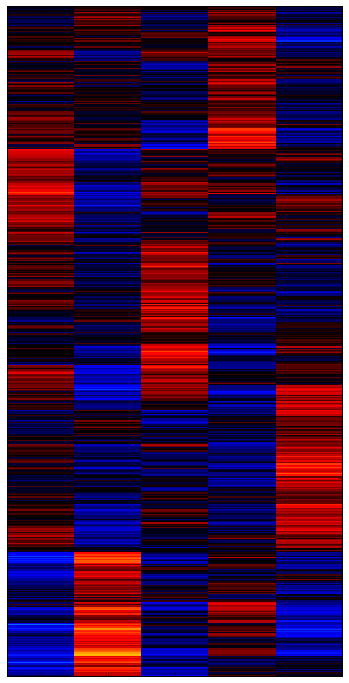

In [41]:
f = plt.figure(figsize=(6,12))
ax = f.add_subplot(111)
tmp = ax.matshow(w_ord, aspect='auto', cmap=bb.visu.hot_cold(), vmin=-0.8, vmax=0.8)
ax.set_xticklabels([])
ax.set_yticklabels([])
fig_name = 'weight_mat_net3.svg'
f.savefig(os.path.join(figure_path, fig_name), transparent=False, bbox_inches='tight',
          pad_inches=0)

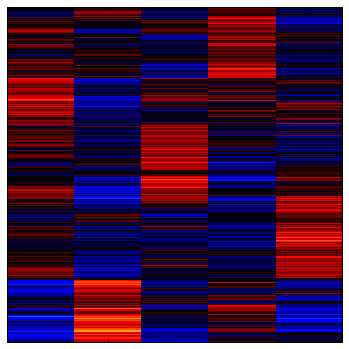

In [42]:
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
tmp = ax.matshow(w_ord, aspect='auto', cmap=bb.visu.hot_cold(), vmin=-0.8, vmax=0.8)
ax.set_xticklabels([])
ax.set_yticklabels([])
fig_name = 'weight_mat_net3_short.svg'
f.savefig(os.path.join(figure_path, fig_name), transparent=False, bbox_inches='tight',
          pad_inches=0)
fig_name = 'weight_mat_net3_short.png'
f.savefig(os.path.join(figure_path, fig_name), transparent=False, bbox_inches='tight',
          pad_inches=0)

In [46]:
part[(order-1)[-50:]]

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [49]:
a = [part[x] for x in order-1]
l = list()
for x in a:
    if not x in l:
        l.append(x)
l

[4.0, 1.0, 3.0, 5.0, 2.0]

"""
# Get the network stack
m_img = nib.load(mas_path)
mask = m_img.get_data().astype(bool)
model = pd.read_csv(model_path)

ns = sio.loadmat('/data1/guilimin/abide/subtype/sc7/full_maybe/network_3/network_3_stack.mat')
stack = ns['stack']
m_vec = np.reshape(mask, np.prod(mask.shape), order='F')

for ids in np.arange(10):
    s_num = model
    s2_name = 'sub_{:07}'.format(model.iloc[sbt2[ids]].SUB_ID.astype(int))
    s3_name = 'sub_{:07}'.format(model.iloc[sbt2[ids]].SUB_ID.astype(int))
    
    tmp2 = np.zeros_like(m_vec, dtype=float)
    tmp2[m_vec] = stack[sbt2[ids], :]
    tmp2 = np.reshape(tmp2, mask.shape, order='F')
    s2_img = nib.Nifti1Image(tmp2, header=m_img.get_header(), affine=m_img.get_affine())
    
    tmp3 = np.zeros_like(m_vec, dtype=float)
    tmp3[m_vec] = stack[sbt3[ids], :]
    tmp3 = np.reshape(tmp3, mask.shape, order='F')
    s3_img = nib.Nifti1Image(tmp3, header=m_img.get_header(), affine=m_img.get_affine())
    
    fig_2 = plt.figure(figsize=(18,6))
    ax = fig_2.add_subplot(111)
    nlp.plot_stat_map(s2_img, display_mode='ortho', threshold=0, annotate=False,
                      black_bg=False,axes=ax, colorbar=False)
    fig2_name = 'regressed_{}_net_3_sbt_2.png'.format(s2_name)
    fig_2.savefig(os.path.join(figure_path, 'sub2', fig2_name), transparent=False, bbox_inches='tight',
            pad_inches=0)
    
    fig_3 = plt.figure(figsize=(18,6))
    ax = fig_3.add_subplot(111)
    nlp.plot_stat_map(s3_img, display_mode='ortho', threshold=0, annotate=False,
                      black_bg=False,axes=ax, colorbar=False)
    fig3_name = 'regressed_{}_net_3_sbt_3.png'.format(s3_name)
    fig_3.savefig(os.path.join(figure_path, 'sub3', fig3_name), transparent=False, bbox_inches='tight',
            pad_inches=0)
    
    fig_2x = plt.figure(figsize=(6,6))
    ax = fig_2x.add_subplot(111)
    nlp.plot_stat_map(s2_img, display_mode='x', threshold=0, annotate=False, cut_coords=[-10],
                      black_bg=False,axes=ax, colorbar=False)
    fig2x_name = 'x_regressed_{}_net_3_sbt_2.png'.format(s2_name)
    fig_2x.savefig(os.path.join(figure_path, 'sub2', fig2x_name), transparent=False, bbox_inches='tight',
            pad_inches=0)
    
    fig_3x = plt.figure(figsize=(6,6))
    ax = fig_3x.add_subplot(111)
    nlp.plot_stat_map(s3_img, display_mode='x', threshold=0, annotate=False, cut_coords=[-10],
                      black_bg=False,axes=ax, colorbar=False)
    fig3x_name = 'x_regressed_{}_net_3_sbt_3.png'.format(s3_name)
    fig_3x.savefig(os.path.join(figure_path,  'sub3', fig3x_name), transparent=False, bbox_inches='tight',
            pad_inches=0)
    
    plt.close()
"""

"""# Now show the raw images
model = pd.read_csv(model_path)
seed_tmp = '/data1/guilimin/abide/sca_z/sc7/netstack_fmri_{:07}_session_1_run1.nii.gz'
for ids in np.arange(10):
    s2_name = 'sub_{:07}'.format(model.iloc[sbt2[ids]].SUB_ID.astype(int))
    s3_name = 'sub_{:07}'.format(model.iloc[sbt2[ids]].SUB_ID.astype(int))
    t_2 = nib.load(seed_tmp.format(model.iloc[sbt2[ids]].SUB_ID.astype(int)))
    t_3 = nib.load(seed_tmp.format(model.iloc[sbt3[ids]].SUB_ID.astype(int)))
    
    fig_2 = plt.figure(figsize=(18,6))
    ax = fig_2.add_subplot(111)
    nlp.plot_stat_map(nil.image.index_img(t_2, 2), display_mode='ortho', threshold=0, annotate=False,
                      black_bg=False,axes=ax, colorbar=False)
    fig2_name = 'raw_{}_net_3_sbt_2.png'.format(s3_name)
    fig_2.savefig(os.path.join(figure_path,'sub2', fig2_name), transparent=False, bbox_inches='tight',
            pad_inches=0)
    
    fig_3 = plt.figure(figsize=(18,6))
    ax = fig_3.add_subplot(111)
    nlp.plot_stat_map(nil.image.index_img(t_3, 2), display_mode='ortho', threshold=0, annotate=False,
                      black_bg=False,axes=ax, colorbar=False)
    fig3_name = 'raw_{}_net_3_sbt_3.png'.format(s3_name)
    fig_3.savefig(os.path.join(figure_path, 'sub3', fig3_name), transparent=False, bbox_inches='tight',
            pad_inches=0)
    
    fig_2x = plt.figure(figsize=(6,6))
    ax = fig_2x.add_subplot(111)
    nlp.plot_stat_map(nil.image.index_img(t_2, 2), display_mode='x', threshold=0, annotate=False, cut_coords=[-10],
                      black_bg=False,axes=ax, colorbar=False)
    fig2x_name = 'x_raw_{}_net_3_sbt_2.png'.format(s2_name)
    fig_2x.savefig(os.path.join(figure_path, 'sub2',fig2x_name), transparent=False, bbox_inches='tight',
            pad_inches=0)
    
    fig_3x = plt.figure(figsize=(6,6))
    ax = fig_3x.add_subplot(111)
    nlp.plot_stat_map(nil.image.index_img(t_3, 2), display_mode='x', threshold=0, annotate=False, cut_coords=[-10],
                      black_bg=False,axes=ax, colorbar=False)
    fig3x_name = 'x_raw_{}_net_3_sbt_3.png'.format(s3_name)
    fig_3x.savefig(os.path.join(figure_path, 'sub3',fig3x_name), transparent=False, bbox_inches='tight',
            pad_inches=0)
    
    plt.close()
"""